In [1]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torchvision.ops import box_convert
from torchvision.transforms import Resize, ToTensor, Compose, Normalize, ColorJitter
import torchvision.models.detection as detection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
labels_dir = './data/BDD100K/labels'
images_dir = './data/BDD100K/100k_images_val/images'
train_label_file = 'det_val_errors.json'
error_ids_file = 'error_ids.json'

dict_keys(['misclassification_err', 'size_alternation_err', 'remove_label_err', 'shifting_err'])


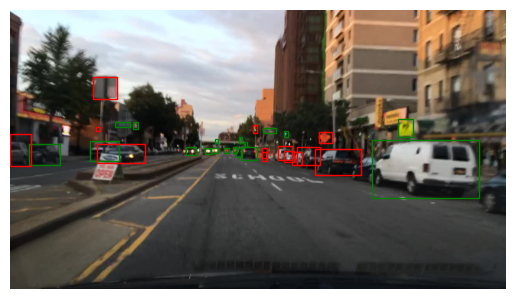

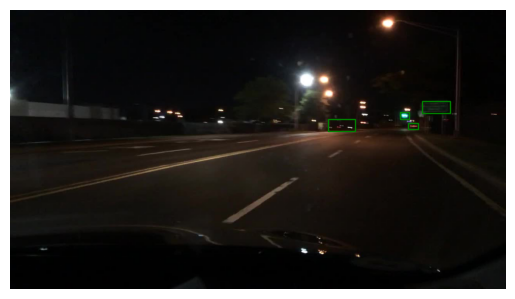

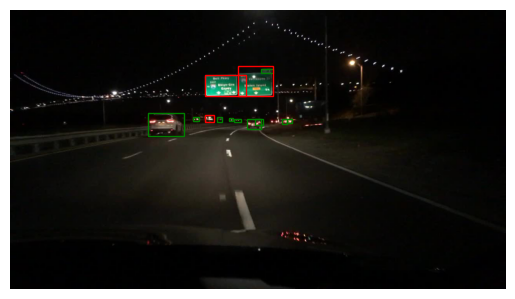

In [3]:
# Read the labels file
with open(os.path.join(labels_dir, train_label_file), 'r') as file:
    label_data = json.load(file)
    
# Read the error ids
with open(os.path.join(labels_dir, error_ids_file), 'r') as file:
    error_ids = json.load(file)
print(error_ids.keys())
error_ids_set = {val for sublist in error_ids.values() for val in sublist}

# Function to plot a single image with bounding boxes
def plot_image_with_boxes(image_path, labels):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for label in labels:
        box = label['box2d']
        x1, y1, x2, y2 = box['x1'], box['y1'], box['x2'], box['y2']
        if label['id'] in error_ids_set:
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        else:
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    plt.axis('off')
    plt.show()

# Plot the first three images with their bounding boxes
for image_data in label_data[:3]:
    image_path = os.path.join(images_dir, image_data['name'])
    plot_image_with_boxes(image_path, image_data['labels'])

In [4]:
class BDD100KDataset(Dataset):
    def __init__(self, label_data, images_dir, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.data = []

        for item in label_data:
            image_path = os.path.join(self.images_dir, item['name'])
            labels = []
            boxes = []
            if os.path.exists(image_path):  # Ensure the image exists
                for label in item['labels']:
                    labels.append(1 if self.is_erroneous(label) else 0)
                    box = label['box2d']
                    boxes.append([box['x1'], box['y1'], box['x2'], box['y2']])

                self.data.append((image_path, boxes, labels))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, boxes, labels = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Convert boxes and labels to tensors
        boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)
        
        return image, boxes_tensor, labels_tensor
    
    @staticmethod
    def is_erroneous(label):
        # Return True if the label is considered erroneous, False otherwise
        return True if label["id"] in error_ids_set else False
    

transform = Compose([
    Resize(800),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = BDD100KDataset(label_data, images_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [5]:
class CustomRCNN(nn.Module):
    def __init__(self):
        super(CustomRCNN, self).__init__()
        # Load a pre-trained Faster R-CNN model
        self.model = detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')
        # Replace the classifier with a new one for binary classification (erroneous or not)
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        # Binary classification (erroneous, not erroneous)
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

    def forward(self, images, targets=None):
        return self.model(images, targets)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = CustomRCNN().to(device)
#criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
print(len(dataloader))

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
        for images, boxes, labels in tepoch:
            images = list(image.to(device) for image in images)
            targets = []
            for i in range(len(images)):
                d = {}
                #d['boxes'] = box_convert(boxes[i].to(device), 'xyxy', 'xywh')
                d['boxes'] = boxes[i].to(device)
                d['labels'] = labels[i].to(device).long()
                targets.append(d)

            optimizer.zero_grad()

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            optimizer.step()

            running_loss += losses.item()
            tepoch.set_postfix(loss=losses.item())
    
    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {running_loss/len(dataloader):.4f}")

Device: cuda
1250


Epoch 1/10: 100%|██████████| 1250/1250 [32:56<00:00,  1.58s/batch, loss=1.01]   


Epoch [1/10], Avg Loss: 39548366211516.9062


Epoch 2/10: 100%|██████████| 1250/1250 [33:06<00:00,  1.59s/batch, loss=1.03] 


Epoch [2/10], Avg Loss: 1.0398


Epoch 3/10: 100%|██████████| 1250/1250 [42:26<00:00,  2.04s/batch, loss=1.09]   


Epoch [3/10], Avg Loss: 1.0371


Epoch 4/10:  26%|██▋       | 331/1250 [08:46<24:23,  1.59s/batch, loss=1.1]  


KeyboardInterrupt: 